# time series analysis

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# loading raw data

In [44]:
df = pd.read_csv('bitstampUSD_1-min_data_2012-01-01_to_2020-04-22.csv')

df["Timestamp"] = pd.to_datetime(df["Timestamp"], unit='s').dt.strftime('%Y/%m/%d - %H:%M')
# give date as index
df.set_index("Timestamp", inplace=True)
print(df.dtypes)

# prendre la fin du document avec un intervalle de 5 minutes
df = df[-1000000::5]
print ("taille de la donnée", len(df))
df.to_csv('output_btc0.csv')


Open                 float64
High                 float64
Low                  float64
Close                float64
Volume_(BTC)         float64
Volume_(Currency)    float64
Weighted_Price       float64
dtype: object
taille de la donnée 200000


## test, plotting "open"

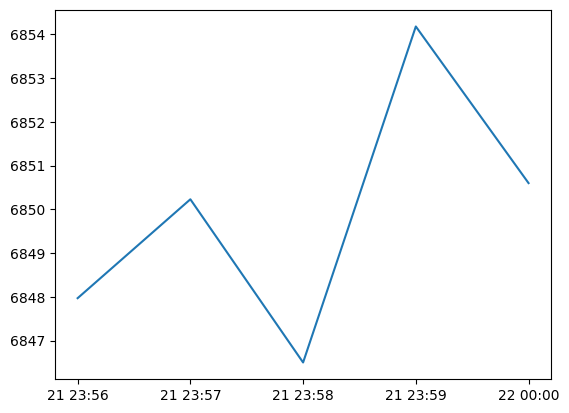

In [27]:
plt.plot(df['Open'].tail(5))
plt.show()



# Selecting the data we want to analyze

<Axes: xlabel='Timestamp'>

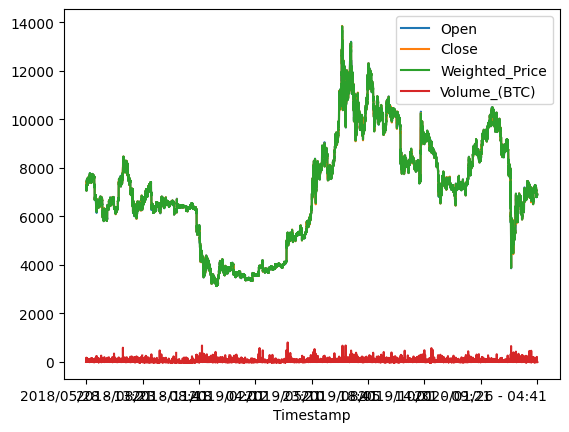

In [48]:
btc = df[ ['Open','Close', 'Weighted_Price', 'Volume_(BTC)'] ]
btc.plot()

# Rescaling

<Axes: >

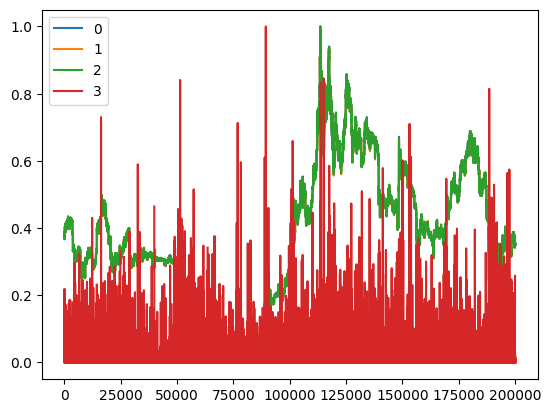

In [49]:
dataset = btc.values
dataset = dataset.astype('float16') 
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# plot
plot = pd.DataFrame(dataset)
plot.plot()

# building the dataset, in train and test

In [50]:
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

## making the windows

In [59]:
from keras.preprocessing.sequence import TimeseriesGenerator

# number of step
seq_size = 24
n_features = 1  # we chose 1 feature, to predict the value of BTC at the close of the following hour

train_generator = TimeseriesGenerator(train, train, length=seq_size, batch_size=1)
print("Total number of samples in the original training data = ", len(train))
print("Total number of samples in the generated data = ", len(train_generator)) 

test_generator = TimeseriesGenerator(test, test, length=seq_size, batch_size=1)
print("Total number of samples in the original training data = ", len(test)) 
print("Total number of samples in the generated data = ", len(test_generator))  


Total number of samples in the original training data =  134000
Total number of samples in the generated data =  133976
Total number of samples in the original training data =  66000
Total number of samples in the generated data =  65976


# Model LSTM construction

In [56]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation

# define model
model = Sequential()
model.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(seq_size, n_features)))
model.add(LSTM(64, activation='relu'))
model.add(Dense(32))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 24, 128)           66560     
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 118,081
Trainable params: 118,081
Non-trainable params: 0
_________________________________________________________________


## train...

In [61]:
history = model.fit(train_generator, validation_data=test_generator,  epochs=10, verbose=2)

Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node 'sequential_1/lstm_2/TensorArrayUnstack/TensorListFromTensor' defined at (most recent call last):
    File "c:\Users\chauv\anaconda3\envs\tf\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\chauv\anaconda3\envs\tf\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\chauv\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "c:\Users\chauv\anaconda3\envs\tf\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "c:\Users\chauv\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "c:\Users\chauv\anaconda3\envs\tf\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\chauv\anaconda3\envs\tf\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\chauv\anaconda3\envs\tf\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\chauv\anaconda3\envs\tf\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\chauv\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "c:\Users\chauv\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "c:\Users\chauv\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "c:\Users\chauv\anaconda3\envs\tf\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "c:\Users\chauv\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "c:\Users\chauv\anaconda3\envs\tf\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "c:\Users\chauv\anaconda3\envs\tf\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\chauv\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3048, in run_cell
      result = self._run_cell(
    File "c:\Users\chauv\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3103, in _run_cell
      result = runner(coro)
    File "c:\Users\chauv\anaconda3\envs\tf\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\chauv\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3308, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\chauv\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3490, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\chauv\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3550, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\chauv\AppData\Local\Temp\ipykernel_12676\1977878818.py", line 1, in <module>
      history = model.fit(train_generator, validation_data=test_generator,  epochs=10, verbose=1)
    File "c:\Users\chauv\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\chauv\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\chauv\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\chauv\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\chauv\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\chauv\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\chauv\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\chauv\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\chauv\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\chauv\anaconda3\envs\tf\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\chauv\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\chauv\anaconda3\envs\tf\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "c:\Users\chauv\anaconda3\envs\tf\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\chauv\anaconda3\envs\tf\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\chauv\anaconda3\envs\tf\lib\site-packages\keras\layers\rnn\base_rnn.py", line 553, in __call__
      return super().__call__(inputs, **kwargs)
    File "c:\Users\chauv\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\chauv\anaconda3\envs\tf\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\chauv\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\chauv\anaconda3\envs\tf\lib\site-packages\keras\layers\rnn\lstm.py", line 625, in call
      last_output, outputs, states = backend.rnn(
    File "c:\Users\chauv\anaconda3\envs\tf\lib\site-packages\keras\backend.py", line 4939, in rnn
      input_ta = tuple(
    File "c:\Users\chauv\anaconda3\envs\tf\lib\site-packages\keras\backend.py", line 4940, in <genexpr>
      ta.unstack(input_)
Node: 'sequential_1/lstm_2/TensorArrayUnstack/TensorListFromTensor'
Specified a list with shape [?,1] from a tensor with shape [1,4]
	 [[{{node sequential_1/lstm_2/TensorArrayUnstack/TensorListFromTensor}}]] [Op:__inference_train_function_6923]